 # Ball detection notebook
 _by Paul-Emmanuel sotir_

## Imports

In [86]:
import os
import sys
import shutil
import pprint as pp
import operator as op
import numpy as np
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt
plt.close('all')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader

from importlib import reload

if '../src/balldetect' not in sys.path:
    sys.path.append('../src/balldetect')
import datasets
import torch_utils
reload(datasets)
reload(torch_utils)

# Torch configuration
use_gpu = torch.cuda.is_available()
cudnn.benchmark = use_gpu  # Enable inbuilt CuDNN auto-tuner TODO: measure preformances without this flag
cudnn.fastest = use_gpu  # Disable this if memory issues

## Basic dataset exploration

In [2]:
dataset = datasets.BallsCFDetection("../datasets/mini_balls")
dl = DataLoader(dataset, batch_size=64, shuffle=True, pin_memory=use_gpu)

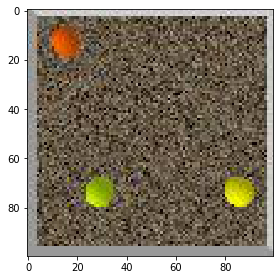

In [3]:
io.imshow(np.asarray(io.imread("../datasets/mini_balls/img_00000.jpg")))

In [12]:
...

Ellipsis

## Task 1: Detection hyperparmeter search results

We ran 3 different hyperparameter searches.  
The last one ([./hp_search_logs/hp_detect3.log](./hp_search_logs/hp_detect3.log)) trains the latest version of the model which performs better:
- First/older hyperparameter search's best trial: __```best_valid_loss=0.0313197```__ (didn't performed well due to early, buggy model implementation) 
- Second hyperparameter search's best trial: __```best_valid_loss=0.0039857```__
- Third/latest hyperparameter search's best trial: __```best_valid_loss=0.0031991```__
 
See following visualizations for better understanding of hyperparameter search results on ball detection model:

##########  BALL DETECTION 3 HYPERPARAMETER SEARCH RESULTS  ##########
Hyperparameter search ran 100 trials. Best trial (30th trial) results:
Best_valid_loss=0.0031991 at epoch=82
Hyperparameters:
("{'architecture': {'act_fn': <class 'torch.nn.modules.activation.ReLU'>, "
 "'batch_norm': {'affine': True, 'eps': 1e-05, 'momentum': "
 "0.07359778246238029}, 'dropout_prob': 0.0, 'layers_param': (('conv2d', "
 "{'kernel_size': (3, 3), 'out_channels': 4, 'padding': 0}), ('conv2d', "
 "{'kernel_size': (3, 3), 'out_channels': 4, 'padding': 0}), ('conv2d', "
 "{'kernel_size': (3, 3), 'out_channels': 4, 'padding': 0}), ('avg_pooling', "
 "{'kernel_size': (2, 2), 'stride': (2, 2)}), ('conv2d', {'kernel_size': (5, "
 "5), 'out_channels': 16, 'padding': 0}), ('conv2d', {'kernel_size': (5, 5), "
 "'out_channels': 16, 'padding': 0}), ('avg_pooling', {'kernel_size': (2, 2), "
 "'stride': (2, 2)}), ('conv2d', {'kernel_size': (5, 5), 'out_channels': 32, "
 "'padding': 2}), ('conv2d', {'kernel_size': (7

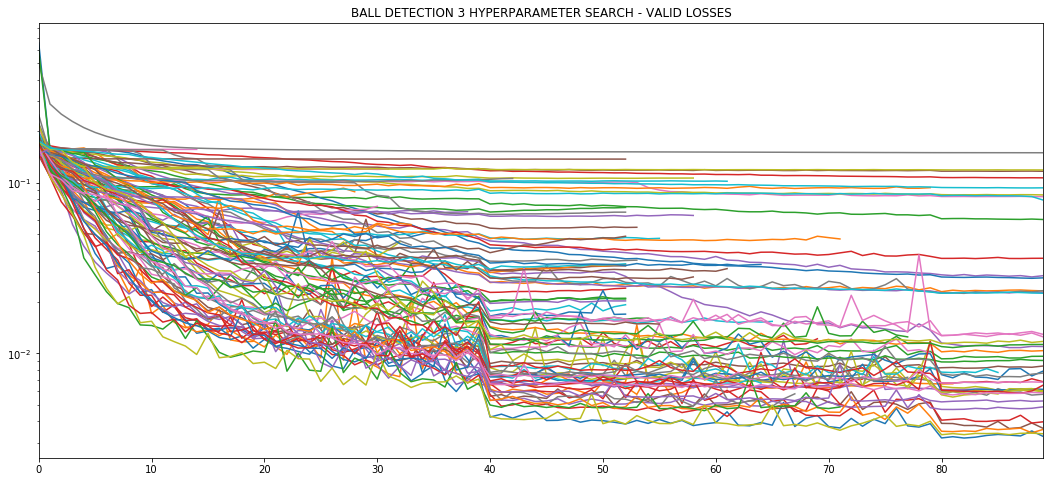

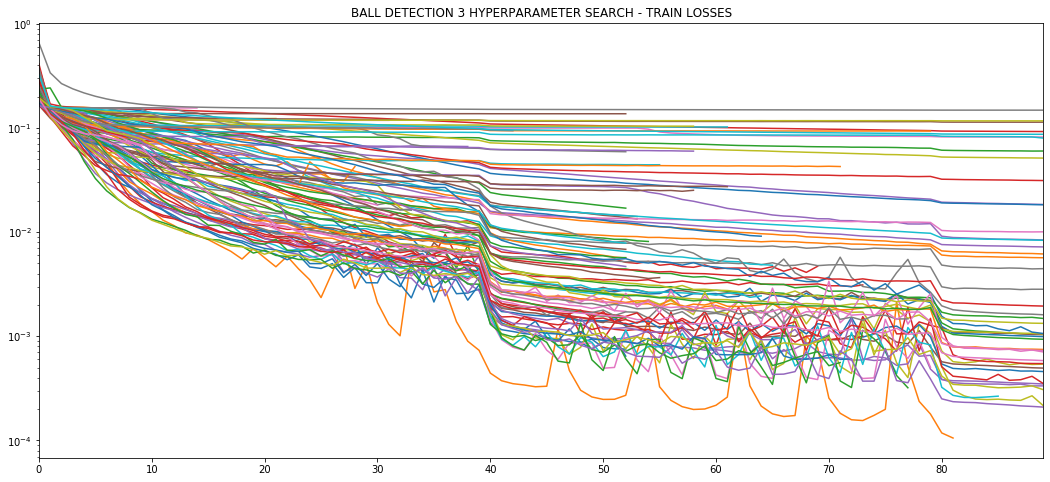

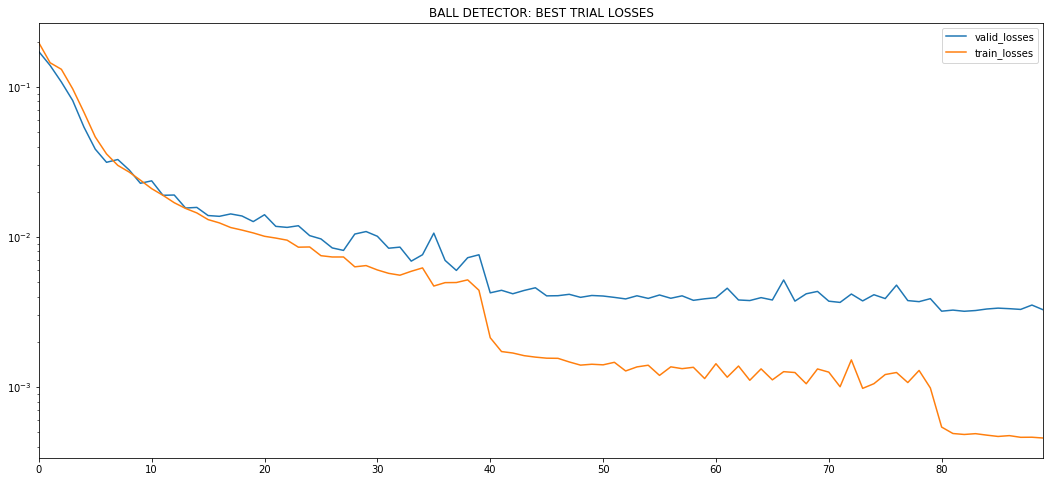

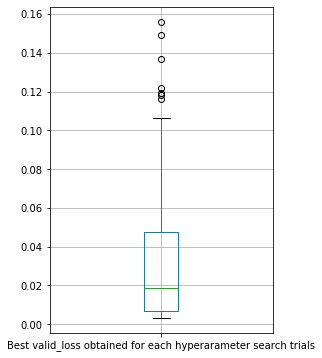

,Best valid_loss obtained for each hyperarameter search trials
count,100.000000
mean,0.034872
std,0.038299
min,0.003199
25%,0.006701
50%,0.018672
75%,0.047386
max,0.156067


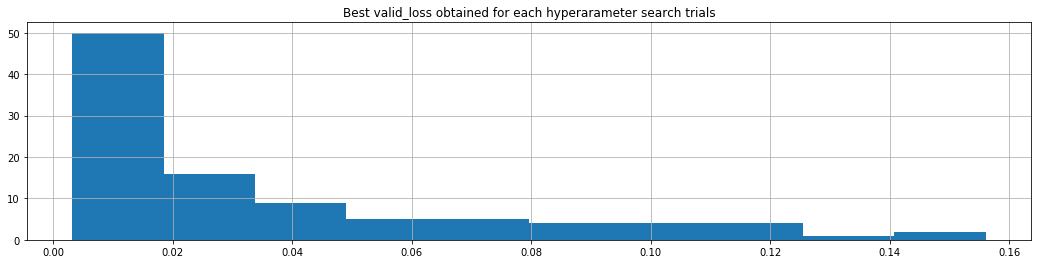

In [109]:
summarize_hp_search(r'../hp_search_logs/hp_detect3.log', 'Ball detection 3')

##########  BALL DETECTION 2 HYPERPARAMETER SEARCH RESULTS  ##########
Hyperparameter search ran 100 trials. Best trial (71th trial) results:
Best_valid_loss=0.0039857 at epoch=82
Hyperparameters:
("{'architecture': {'act_fn': <class 'torch.nn.modules.activation.ReLU'>, "
 "'batch_norm': {'affine': True, 'eps': 1e-05, 'momentum': "
 "0.10000855478007505}, 'dropout_prob': 0.0, 'layers_param': (('conv2d', "
 "{'kernel_size': (3, 3), 'out_channels': 4, 'padding': 0}), ('conv2d', "
 "{'kernel_size': (3, 3), 'out_channels': 4, 'padding': 0}), ('conv2d', "
 "{'kernel_size': (3, 3), 'out_channels': 4, 'padding': 0}), ('avg_pooling', "
 "{'kernel_size': (2, 2), 'stride': (2, 2)}), ('conv2d', {'kernel_size': (5, "
 "5), 'out_channels': 16, 'padding': 0}), ('conv2d', {'kernel_size': (5, 5), "
 "'out_channels': 16, 'padding': 0}), ('avg_pooling', {'kernel_size': (2, 2), "
 "'stride': (2, 2)}), ('conv2d', {'kernel_size': (5, 5), 'out_channels': 32, "
 "'padding': 2}), ('conv2d', {'kernel_size': (7

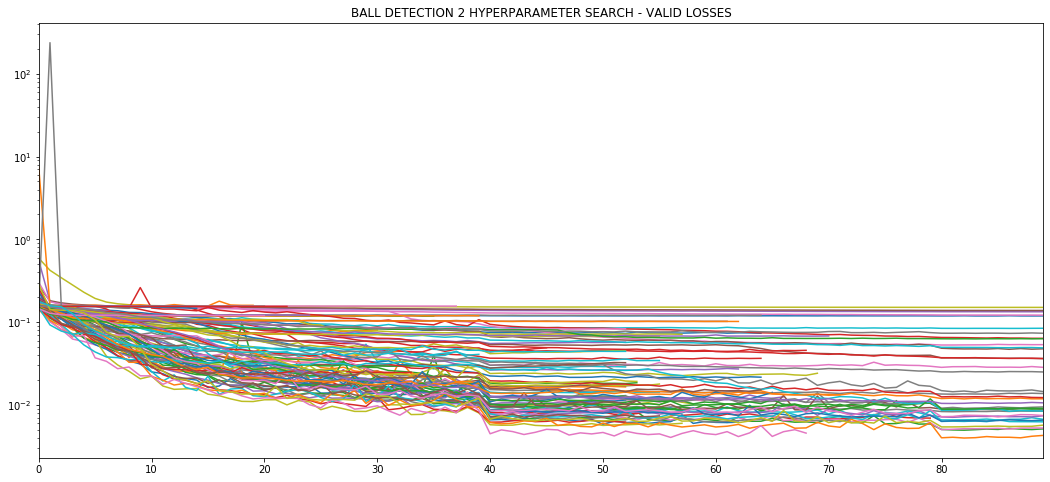

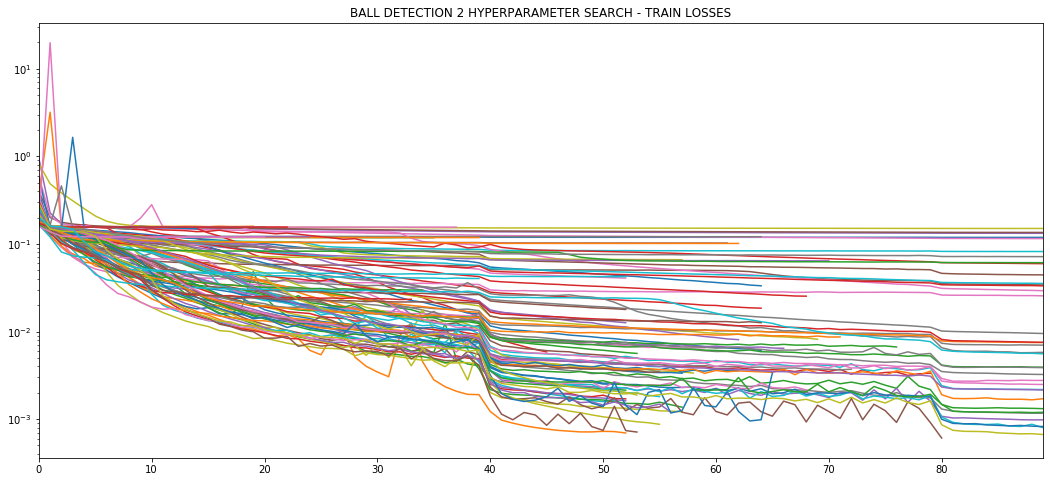

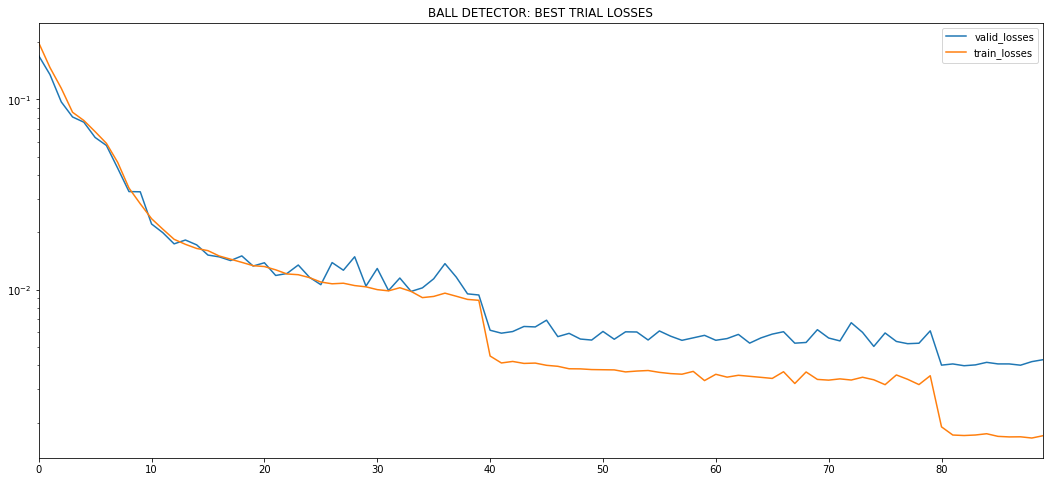

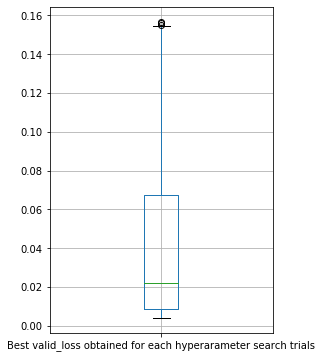

,Best valid_loss obtained for each hyperarameter search trials
count,100.000000
mean,0.044048
std,0.046648
min,0.003986
25%,0.008889
50%,0.021954
75%,0.067262
max,0.156816


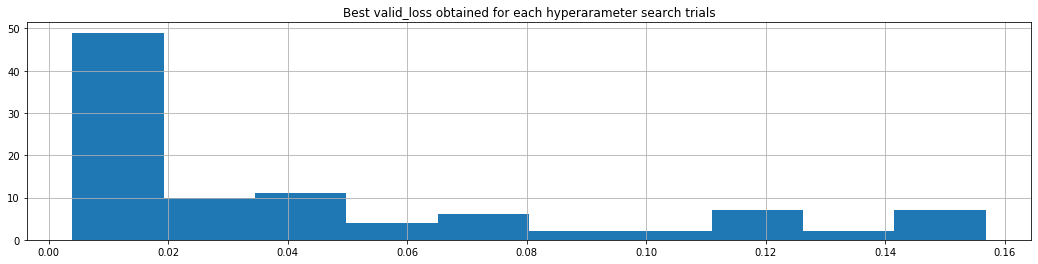

In [107]:
summarize_hp_search(r'../hp_search_logs/hp_detect2.log', 'Ball detection 2')

##########  BALL DETECTION 1 HYPERPARAMETER SEARCH RESULTS  ##########
Hyperparameter search ran 100 trials. Best trial (78th trial) results:
Best_valid_loss=0.0313197 at epoch=89
Hyperparameters:
("{'architecture': {'act_fn': <class 'torch.nn.modules.activation.LeakyReLU'>, "
 "'conv2d_params': ({'kernel_size': (3, 3), 'out_channels': 4, 'padding': 1}, "
 "{'kernel_size': (3, 3), 'out_channels': 4, 'padding': 1}, {'kernel_size': "
 "(3, 3), 'out_channels': 8, 'padding': 1}, {'kernel_size': (3, 3), "
 "'out_channels': 8, 'padding': 1, 'stride': 2}, {'kernel_size': (5, 5), "
 "'out_channels': 16, 'padding': 2}), 'dropout_prob': 1.0, 'fc_params': "
 "({'out_features': 64}, {'out_features': 128})}, 'batch_size': 32, "
 "'optimizer_params': {'amsgrad': False, 'betas': (0.9, 0.999), 'eps': 1e-08, "
 "'lr': 9.40322636322488e-05, 'weight_decay': 3.5870764284550168e-06}, "
 "'scheduler_params': {'gamma': 1.0, 'step_size': 90}}")


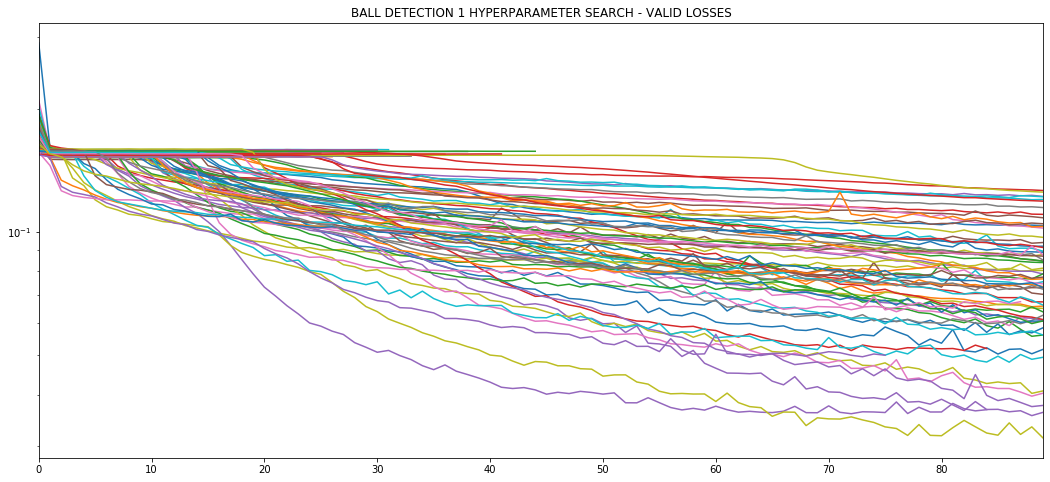

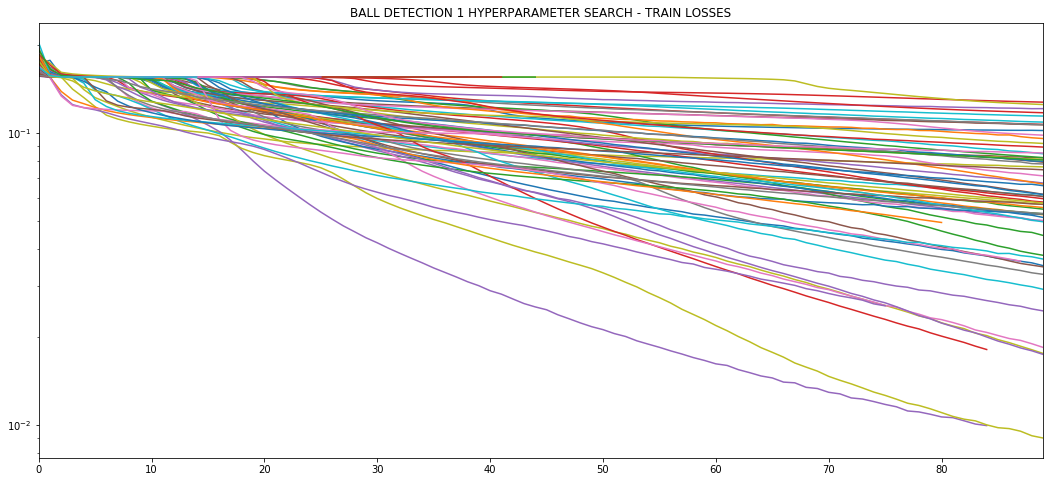

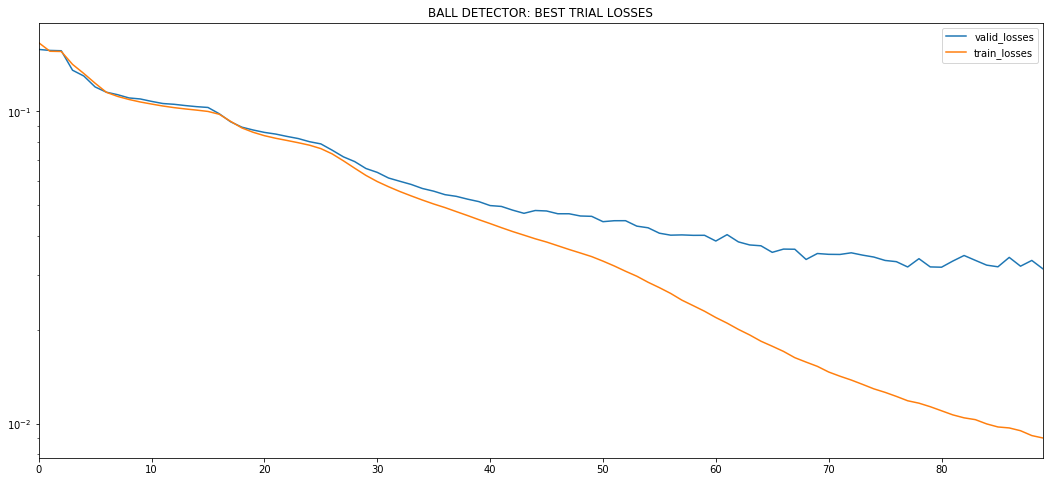

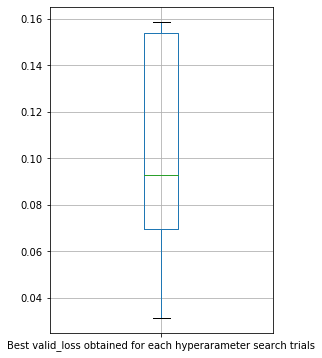

,Best valid_loss obtained for each hyperarameter search trials
count,100.000000
mean,0.104104
std,0.041804
min,0.031320
25%,0.069580
50%,0.092948
75%,0.153632
max,0.158702


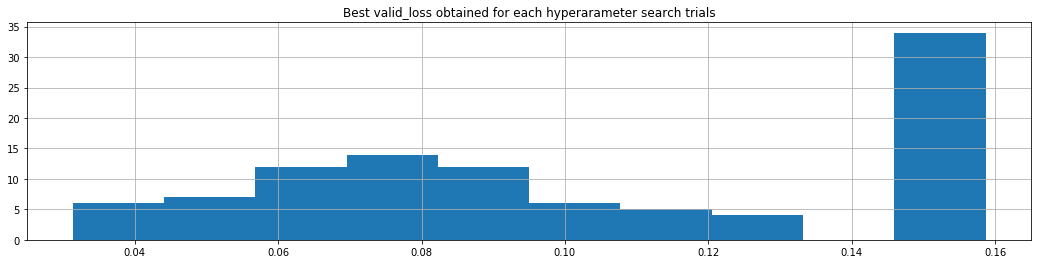

In [108]:
summarize_hp_search(r'../hp_search_logs/hp_detect1.log', 'Ball detection 1')

## Task 2: Ball position forecasting hyperparameter search results

We ran 2 different hyperparameter searches.  
- The last one ([./hp_search_logs/hp_forecast2.log](./hp_search_logs/hp_forecast2.log)) trains the latest version of the model. 
- The first one runs an early version of ball position forecasting model ([./hp_search_logs/hp_forecast1.log](./hp_search_logs/hp_forecast1.log))  

Even thought the first hyperparameter search did found a better model (__```best_valid_mse=0.0005018```__) than the lastest hp search (__```best_valid_mse=0.0003088```__), the latest model version seems to be more promizing for further improvements during a full/regular training with more that 90 epochs. Indeed, first/older hp search trials globaly didn't performed better and we can suspect that its best trial is overfitting on validset much more than the best trial of the newer/latest hp search:  
- According to the following visualizations, the distribution of best validation losses of each trials is better in the latest hp search than in the first one, where the best trial could be an overfitted outlier rather than a promizing hyperparameter search sub-space.  
- Moreover, __train_loss__ and __valid_loss__ curve plots of first/older hp search's best trial displays an important offset between __train_loss__ and __valid_loss__: __valid_loss__ is significantly below __train_loss__ (note that plots uses logarithmic scale for y axis, which means this offset is even larger than it lokks like on plots). This offset doesn't nescessarly mean there is important underfitting on trainset, but rather means that there is very probable overfitting on validset due to hyperparameter search.  
- Another reason of this difference is related to the fact that we used multiple steps of learning rate schedule in the latest hp search while we used a lower, constant learning rate during the first hyperparameter search.  

##########  BALL POSITION FORECASTING 2 HYPERPARAMETER SEARCH RESULTS  ##########
Hyperparameter search ran 100 trials. Best trial (74th trial) results:
Best_valid_loss=0.0005018 at epoch=76
Hyperparameters:
("{'architecture': {'act_fn': <class 'torch.nn.modules.activation.Tanh'>, "
 "'dropout_prob': 0.44996724122672166, 'fc_params': ({'out_features': 512}, "
 "{'out_features': 256}, {'out_features': 128}, {'out_features': 128})}, "
 "'batch_size': 16, 'optimizer_params': {'amsgrad': False, 'betas': (0.9, "
 "0.999), 'eps': 1e-08, 'lr': 9.891933484569264e-05, 'weight_decay': "
 "0.00020217734556558288}, 'scheduler_params': {'gamma': 0.3, 'step_size': "
 '30}}')


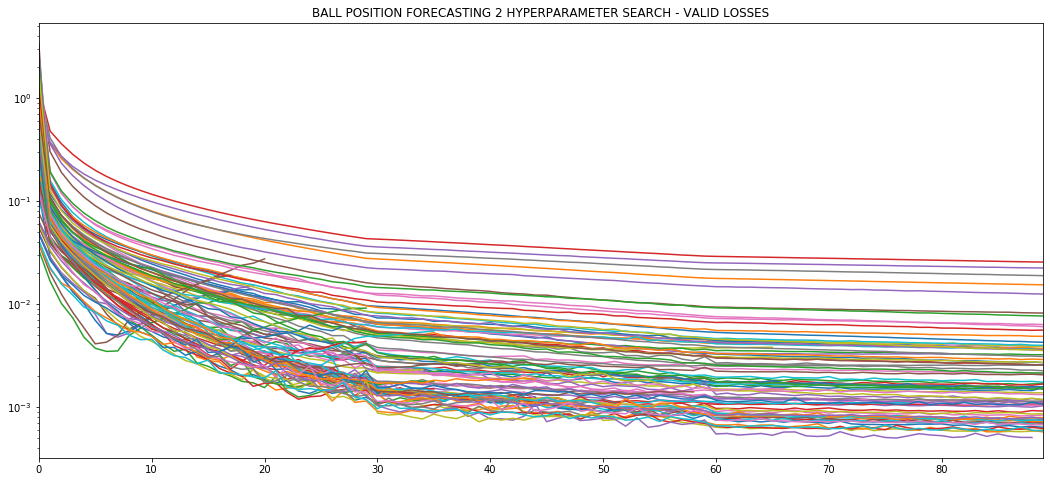

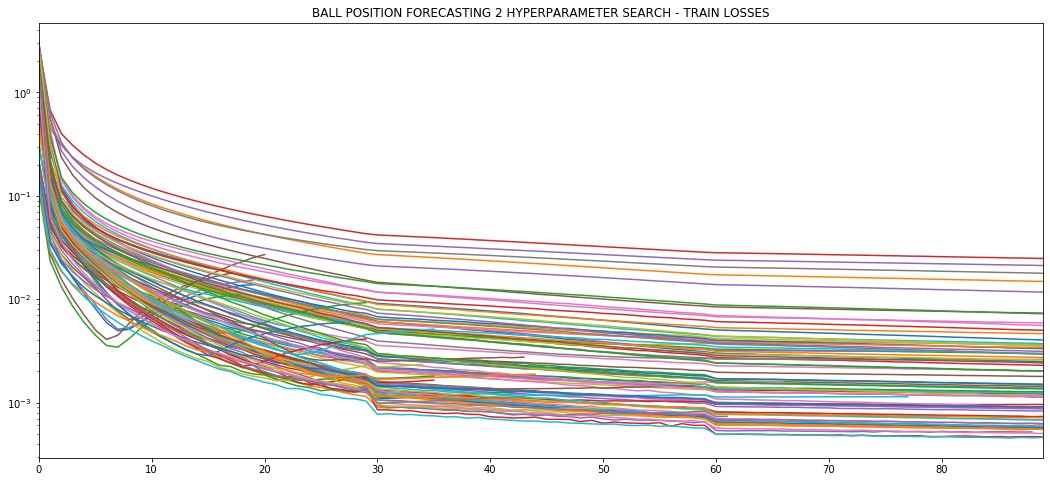

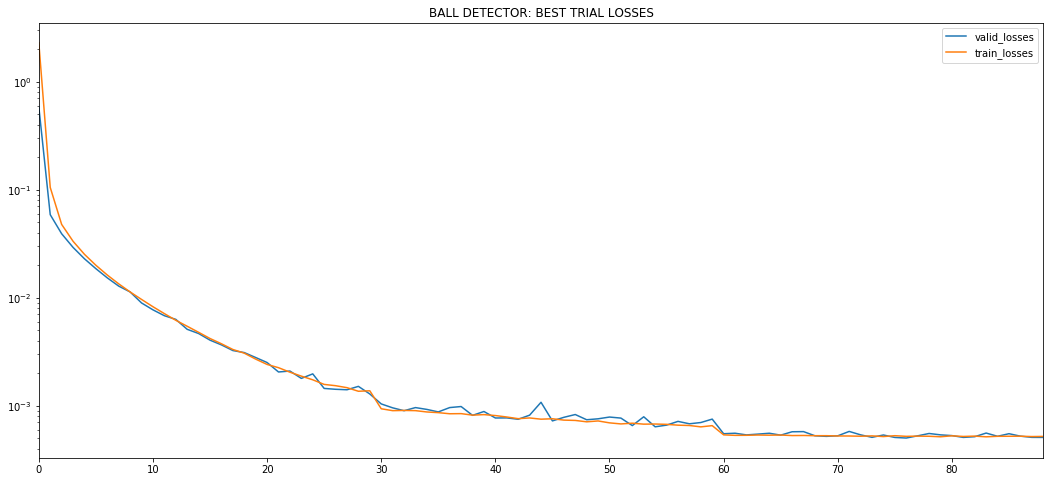

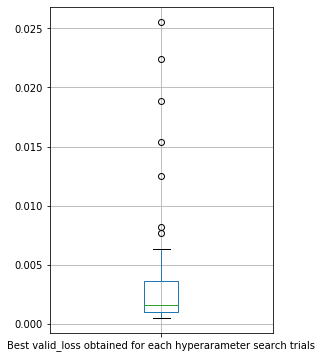

,Best valid_loss obtained for each hyperarameter search trials
count,100.000000
mean,0.003077
std,0.004137
min,0.000502
25%,0.001045
50%,0.001618
75%,0.003594
max,0.025560


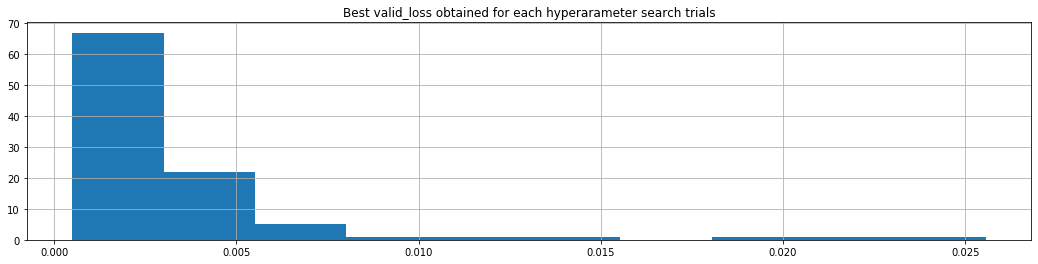

In [103]:
summarize_hp_search(r'../hp_search_logs/hp_forecast2.log', 'Ball position forecasting 2')

##########  BALL POSITION FORECASTING 1 HYPERPARAMETER SEARCH RESULTS  ##########
Hyperparameter search ran 100 trials. Best trial (72th trial) results:
Best_valid_loss=0.0003088 at epoch=69
Hyperparameters:
("{'architecture': {'act_fn': <class 'torch.nn.modules.activation.Tanh'>, "
 "'dropout_prob': 1.0, 'fc_params': ({'out_features': 512}, {'out_features': "
 "256}, {'out_features': 128}, {'out_features': 128})}, 'batch_size': 32, "
 "'optimizer_params': {'amsgrad': False, 'betas': (0.9, 0.999), 'eps': 1e-08, "
 "'lr': 9.065637320023906e-05, 'weight_decay': 2.636242890889078e-06}, "
 "'scheduler_params': {'gamma': 1.0, 'step_size': 90}}")


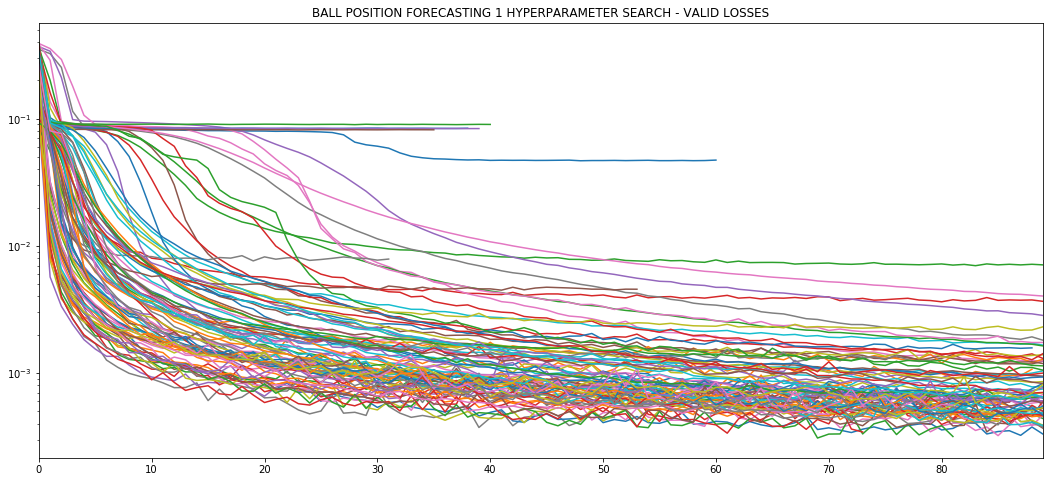

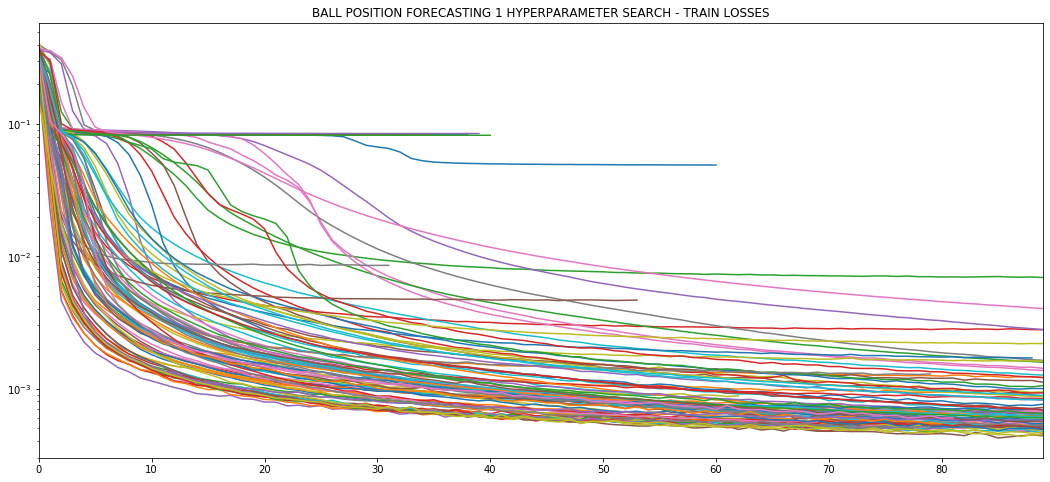

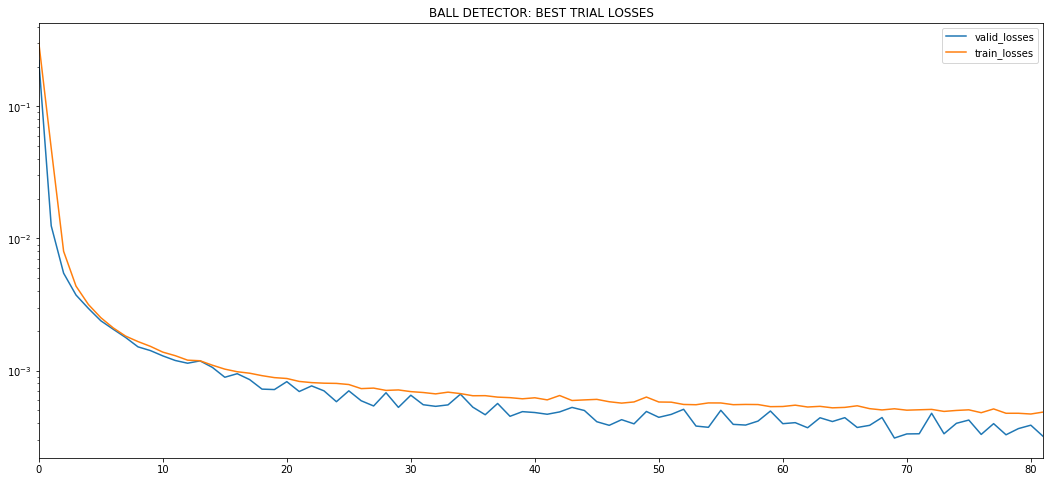

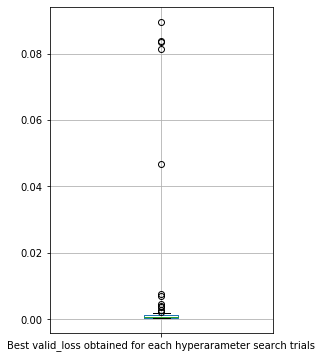

,Best valid_loss obtained for each hyperarameter search trials
count,100.000000
mean,0.004782
std,0.017039
min,0.000309
25%,0.000479
50%,0.000614
75%,0.001150
max,0.089641


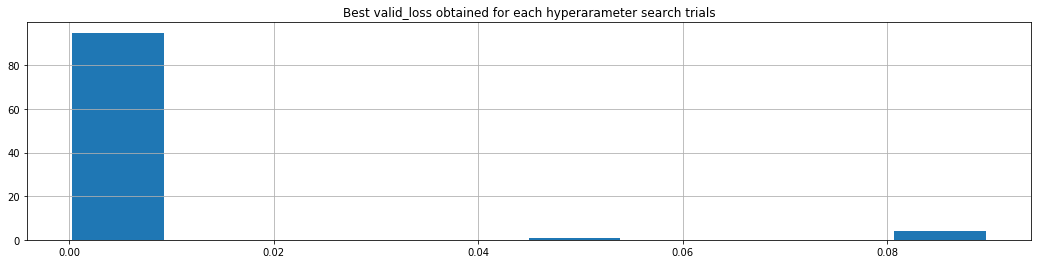

In [104]:
summarize_hp_search(r'../hp_search_logs/hp_forecast1.log', 'Ball position forecasting 1')